<a href="https://colab.research.google.com/github/RohitGanji/NLP-Medical-Paper-Abstracts-Classification/blob/main/Medical_Paper_Abstracts_Classification_using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Paper Abstracts Classification using NLP

This project is an implementation of the paper "Neural Networks for Joint Sentence Classification in Medical Abstracts".

Paper - https://arxiv.org/pdf/1612.05251.pdf

## Preparing Data

### Downloading Dataset

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


### Unzipping train dataset

The train data is in zip format. Let's unzip it.

In [ ]:
!unzip /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip -d /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt  


In [ ]:
DIR = "pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

### Preprocessing data

In [ ]:
def get_lines(filename):
  """
  Reads a filename and returns a list of lines of text

  Args:
      filename: path of the file

  Returns:
      A list of strings with one string per line from filename.
  """
  with open(filename) as f:
    return f.readlines()

In [ ]:
def preprocess(filename):
  """ 
  Returns a list of dictionaries of abstract line data.

  Args: 
      filename: path of the filename (train, test, dev)
  Returns:
      List of dictionary each containing a line from abstract, the line's label, the line's position in the abstract, and the total number of lines in the dataset where the line is from.
  """

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line
  
  return abstract_samples

In [ ]:
train_samples = preprocess(DIR+"train.txt")
val_samples = preprocess(DIR+"dev.txt")
test_samples = preprocess(DIR+"test.txt")

### Viewing our data

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10


In [ ]:
train_df.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

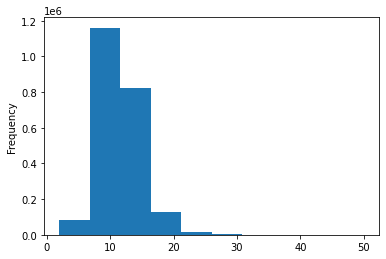

In [ ]:
train_df.total_lines.plot.hist();

It seems like length of most of the abstracts are between 7 and 17.

## Creating Datasets

### Converting data to numeric labels

In [ ]:
# Create one-hot-encoded tensors of "target" column

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

train_labels_one_hot = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = ohe.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = ohe.transform(test_df["target"].to_numpy().reshape(-1, 1))

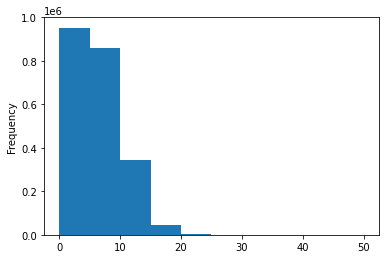

In [ ]:
train_df.line_number.plot.hist();

In [ ]:
# Create one-hot-encoded tensors of "line_number" column

import tensorflow as tf

train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

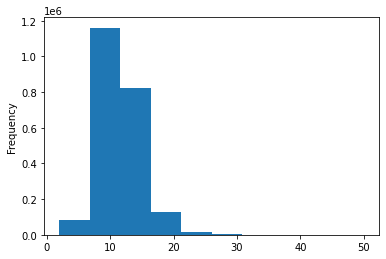

In [ ]:

train_df.total_lines.plot.hist();

In [ ]:
import numpy as np

np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Create one-hot-encoded tensors of "total_lines" column

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

### Converting abstract lines to lists

In [ ]:
# Convert abstract text lines into lists of sentences
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(2211861, 28932, 29493)

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
char_len = int(np.percentile(char_lens, 95))

In [ ]:
# Convert abstract text sentences into lists of characters

def split_chars(text):
  return " ".join(list(text))
  
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

### Creating Tensor Datasets

In [ ]:
# Train Dataset
train_input = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                  train_total_lines_one_hot,
                                                  train_sentences,
                                                  train_chars))
train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_input, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Val Dataset
val_input = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                val_total_lines_one_hot,
                                                val_sentences,
                                                val_chars))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_input, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Test Dataset
test_input = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                 test_total_lines_one_hot,
                                                 test_sentences,
                                                 test_chars))
test_dataset = test_input.batch(32).prefetch(tf.data.AUTOTUNE)

## Model

### Creating layers

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

char_lens = [len(sentence) for sentence in train_sentences]
char_len = int(np.percentile(char_lens, 95))

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Embedding Layer
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable=False,
                                 name="USE")

In [ ]:
# Character Vectorizer
char_vectorizer = TextVectorization(max_tokens = len(alphabet)+2,
                                    output_sequence_length = char_len,
                                    standardize = "lower_and_strip_punctuation",
                                    name = "char_vectorizer")

In [ ]:
char_vectorizer.adapt(train_chars[:500000])
char_vectorizer.adapt(train_chars[500000:1000000])
char_vectorizer.adapt(train_chars[1000000:1500000])
char_vectorizer.adapt(train_chars[1500000:2000000])
char_vectorizer.adapt(train_chars[2000000:])

In [ ]:
# Character Embedding
char_embed = tf.keras.layers.Embedding(input_dim=len(alphabet) + 2,
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

### Model Architecture

In [ ]:
from tensorflow.keras import layers

# Sentence Inputs
sentence_inputs = layers.Input(shape=[], dtype="string", name="sentence_inputs")
sentence_embeddings = embedding_layer(sentence_inputs)
sentence_outputs = layers.Dense(128, activation="relu")(sentence_embeddings)
sentence_model = tf.keras.Model(inputs=sentence_inputs,
                                outputs=sentence_embeddings)

# Character Inputs
character_inputs = layers.Input(shape=(1,), dtype="string", name="character_inputs")
character_vectors = char_vectorizer(character_inputs)
character_embeddings = char_embed(character_vectors)
character_outputs = layers.Bidirectional(layers.LSTM(32))(character_embeddings)
character_model = tf.keras.Model(inputs=character_inputs,
                                 outputs=character_outputs)

# Line Number Inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_outputs)

# Total Lines Inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_outputs)

# Sentence and Character Hybrid Embedding
sentence_character_hybrid = layers.Concatenate(name="sentence_character_hybrid")([sentence_model.output, character_model.output])
hidden_layer = layers.Dense(256, activation="relu")(sentence_character_hybrid)
hidden_layer = layers.Dropout(0.5)(hidden_layer)

# Combine Line Number, Total Lines and Last Hidden Layer

mega_layer = layers.Concatenate(name="mega_layer")([line_number_model.output,
                                                    total_lines_model.output,
                                                    hidden_layer])

# Output Layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(mega_layer)

# Model
model = tf.keras.Model(inputs=[line_number_model.input,
                               total_lines_model.input,
                               sentence_model.input,
                               character_model.input],
                       outputs=output_layer)

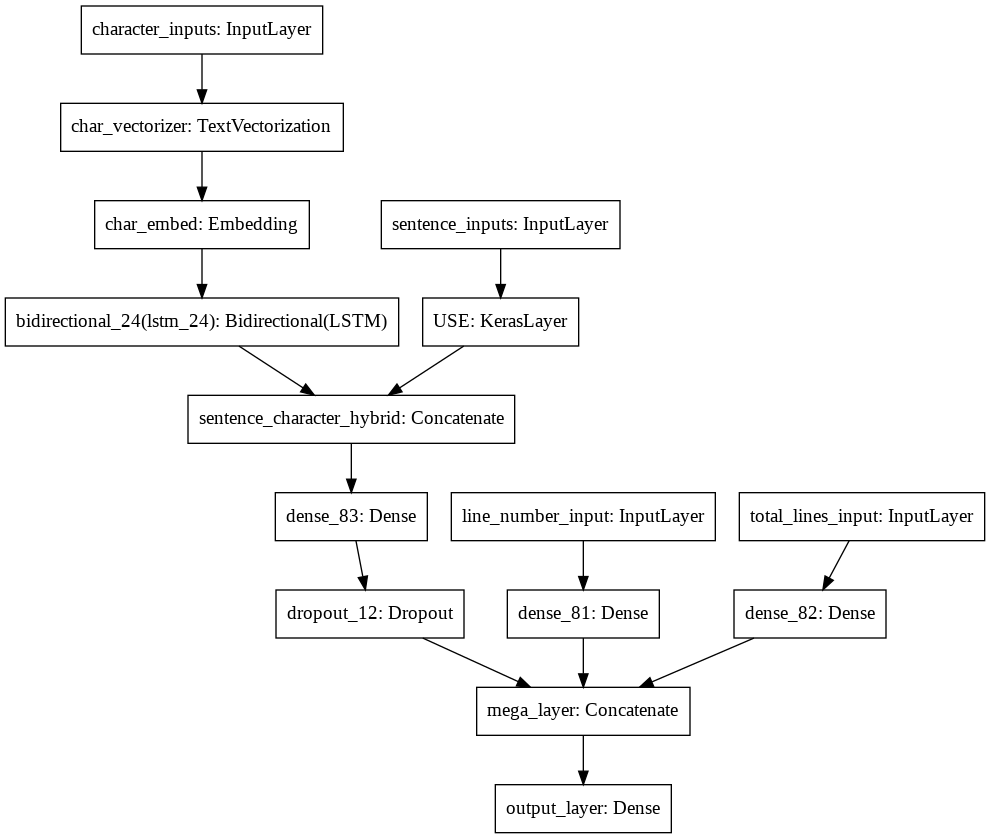

In [ ]:
tf.keras.utils.plot_model(model)

### Compiling the Model

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

### Fitting the Model

In [ ]:
history = model.fit(train_dataset,
                    steps_per_epoch=int(0.1*len(train_dataset)),
                    epochs=3,
                    validation_data=val_dataset,
                    validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
6912/6912 [==============================] - 324s 45ms/step - loss: 0.9509 - accuracy: 0.8262 - val_loss: 0.9168 - val_accuracy: 0.8549
Epoch 2/3
6912/6912 [==============================] - 295s 43ms/step - loss: 0.9215 - accuracy: 0.8478 - val_loss: 0.9058 - val_accuracy: 0.8608
Epoch 3/3
6912/6912 [==============================] - 296s 43ms/step - loss: 0.9168 - accuracy: 0.8514 - val_loss: 0.9001 - val_accuracy: 0.8642


Due to the lack of GPU, i've only trained for 3 epochs. You can expect better results by training for more epochs and adding callbacks.

## Plotting Graphs

In [ ]:
import matplotlib.pyplot as plt

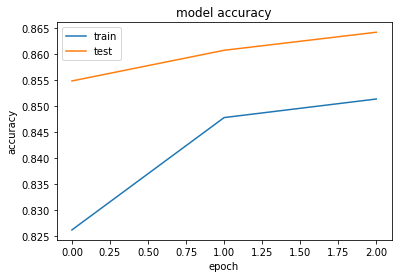

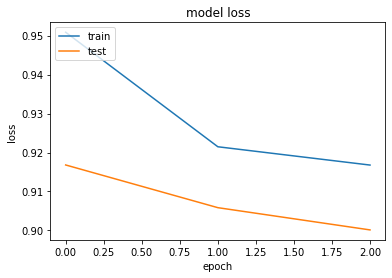

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()